In [96]:
import warnings
from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

In [116]:
# function cm_val creates an interactive confusion matrix on un-scaled data.
# function cm_val_scaled creates an interactive confusion matrix on scaled data.
from my_functions import cm_val
from my_functions import cm_val_scaled
# function y_pred_inverse extracts the predictive probability from predict_proba.
from my_functions import y_pred_inverse
# function plot_validation_curve_log plots a validation curve on a log scale.
# function plot_validation_curve_reg plots a validation curve on a default scale.
from my_functions import plot_validation_curve_log
from my_functions import plot_validation_curve_reg
# function plot_learning_curve_reg plots a learning curve on a default scale.
from my_functions import plot_learning_curve
# function plot_decision_tree uses graphviz to visualize the splits of a devision tree.
from my_functions import plot_decision_tree
# function train_and_calibrate_cv performs stratified shuffle split on a specified model,
# returning validation scores and roc/auc.
from my_functions import train_and_calibrate_cv

In [117]:
warnings.filterwarnings('ignore')

In [118]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', None)

In [119]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [120]:
np.random.seed(42)

In [121]:
df = pd.read_pickle('pickle/df_modeling.pkl')

In [122]:
len(df)

9115

In [178]:
X = df.drop(['cow_code', 'year', 'state_name', 'export_import_ratio', 'avg_hostility_level',
             'revision_pct', 'democratic_regime', 'cabinet_assembly', 'popular_election',
             'Civilian dictatorship', 'Military dictatorship',
             'Mixed (semi‐presidential) democracy', 'Parliamentary democracy',
             'Presidential democracy', 'Royal dictatorship',
             'transition_to_democracy', 'transition_to_dictatorship',
             'Direct election', 'Indirect election', 'Nonelective',
             'Elective legislature', 'No legislature exists',
             'Non‐elective legislature', 'Appointed', 'Closed', 'Elected',
             'All parties legally banned', 'Legally single party state',
             'Multiple parties legally allowed', 'Elective legislature',
             'No legislature exists', 'Non‐elective legislature', 'Multiple parties',
             'No parties', 'One party', 'Legislature with multiple parties',
             'No legislature or all nonpartisan', 'Only members from regime party',
             'Democratic incumbent', 'Rules rewritten unconstitutionally',
             'leader_tenure', 'royal_leader', 'communist_leader',
             'num_transitions_ever', 'num_leadership_changes', 'age_govt',
             'cinc_score', 'nominal_vs_eff_diff'], axis = 1)

y = df['democratic_regime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [179]:
df['democratic_regime'].value_counts()

0    5120
1    3995
Name: democratic_regime, dtype: int64

In [180]:
df.groupby('democratic_regime').mean()

,cow_code,year,num_trade_states,export_dollars,import_dollars,military_expenditure,military_personnel,prim_energy_consumption,total_pop,cinc_score,num_alliances,pre_1816_alliances,num_in_effect_1231_2012,defense_treaties,neutrality_treaties,nonaggression_treaties,entente_treaties,num_conflicts,avg_cum_duration,num_wars,ongoing_2010,revision_pct,avg_hostility_level,num_leadership_changes,leader_tenure,age_govt,num_transitions_ever,export_import_ratio,Africa,Americas,Asia,Europe,Oceania,Direct election,Indirect election,Nonelective,Elective legislature,No legislature exists,Non‐elective legislature,Appointed,Closed,Elected,All parties legally banned,Legally single party state,Multiple parties legally allowed,Elective legislature,No legislature exists,Non‐elective legislature,Multiple parties,No parties,One party,Legislature with multiple parties,No legislature or all nonpartisan,Only members from regime party,Democratic incumbent,Rules rewritten unconstitutionally,collective_leadership,military_leader,royal_leader,nominal_vs_eff_diff,communist_leader,leader_died,cabinet_assembly,popular_election,Civilian dictatorship,Military dictatorship,Mixed (semi‐presidential) democracy,Parliamentary democracy,Presidential democracy,Royal dictatorship,transition_to_democracy,transition_to_dictatorship,war_present,40s,50s,60s,70s,80s,90s
democratic_regime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,523.727,1979.779,149.138,5746329787.325,6892921108.655,2159463201.550,171596.191,90964942578.125,28064008.594,0.006,11.912,0.006,9.216,7.791,0.170,9.207,9.617,0.744,0.285,0.058,0.002,0.152,1.779,0.135,10.511,30.423,0.281,2.386,0.414,0.119,0.340,0.103,0.023,0.299,0.219,0.482,0.722,0.192,0.086,0.074,0.227,0.692,0.187,0.206,0.603,0.722,0.192,0.086,0.480,0.175,0.341,0.350,0.335,0.309,0.938,0.062,0.005,0.331,0.152,0.151,0.135,0.019,0.012,0.014,0.517,0.331,0.000,0.000,0.000,0.152,0.000,0.013,0.030,0.031,0.093,0.158,0.207,0.204,0.169
1,367.895,1984.711,158.086,32238872416.030,30776371811.746,5301243217.913,137168.586,177869482352.941,30735892.365,0.009,14.873,0.024,13.802,13.910,0.304,10.913,13.473,0.556,0.197,0.034,0.003,0.117,1.560,0.338,3.709,32.562,0.431,inf,0.076,0.309,0.147,0.372,0.096,0.318,0.679,0.003,0.998,0.002,0.001,0.000,0.000,1.000,0.000,0.000,1.000,0.998,0.002,0.001,0.992,0.008,0.000,0.986,0.009,0.005,1.000,0.000,0.024,0.067,0.000,0.002,0.001,0.010,0.720,0.414,0.000,0.000,0.172,0.548,0.279,0.000,0.027,0.000,0.022,0.036,0.095,0.106,0.107,0.152,0.251


In [181]:
# performed StratifiedShuffleSplit to training data (80%) into training (60%) and validation (20%)
# skf = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 101)
# for train_index, validation_index in skf.split(X_train, y_train):
#     X_train_6 = X_train.iloc[train_index]
#     y_train_6 = y_train.iloc[train_index]
#     X_validation_2 = X_train.iloc[validation_index]
#     y_validation_2 = y_train.iloc[validation_index]

In [182]:
continuous_columns = ['num_trade_states', 'export_dollars', 'import_dollars',
                      'military_expenditure', 'military_personnel',
                      'prim_energy_consumption', 'total_pop',
                      'num_alliances', 'pre_1816_alliances', 'num_in_effect_1231_2012',
                      'defense_treaties', 'neutrality_treaties', 'nonaggression_treaties',
                      'entente_treaties', 'avg_cum_duration', 'ongoing_2010']

X_train_cont = X_train[continuous_columns]
X_train_cont = X_train_cont.reset_index()
X_train_cont.drop(['index'], axis = 1, inplace = True)

X_train_dummy = X_train.drop(continuous_columns, axis = 1)
X_train_dummy = X_train_dummy.reset_index()
X_train_dummy.drop(['index'], axis = 1, inplace = True)

X_test_cont = X_test[continuous_columns]
X_test_cont = X_test_cont.reset_index()
X_test_cont.drop(['index'], axis = 1, inplace = True)

X_test_dummy = X_test.drop(continuous_columns, axis = 1)
X_test_dummy = X_test_dummy.reset_index()
X_test_dummy.drop(['index'], axis = 1, inplace = True)

In [183]:
scaler = MinMaxScaler()

X_train_cont_scaled = pd.DataFrame(scaler.fit_transform(X_train_cont))
X_train_cont_scaled = X_train_cont_scaled.reset_index()
X_train_cont_scaled.drop(['index'], axis = 1, inplace = True)
X_train_cont_scaled.columns = continuous_columns

X_test_cont_scaled = pd.DataFrame(scaler.transform(X_test_cont))
X_test_cont_scaled = X_test_cont_scaled.reset_index()
X_test_cont_scaled.drop(['index'], axis = 1, inplace = True)
X_test_cont_scaled.columns = continuous_columns

X_train_scaled = pd.concat([X_train_cont_scaled, X_train_dummy], axis = 1)
X_test_scaled = pd.concat([X_test_cont_scaled, X_test_dummy], axis = 1)

In [184]:
df_scaled = pd.DataFrame(X_train_scaled, columns = X_train_scaled.columns)
df_scaled.head()

,num_trade_states,export_dollars,import_dollars,military_expenditure,military_personnel,prim_energy_consumption,total_pop,num_alliances,pre_1816_alliances,num_in_effect_1231_2012,defense_treaties,neutrality_treaties,nonaggression_treaties,entente_treaties,avg_cum_duration,ongoing_2010,num_conflicts,num_wars,Africa,Americas,Asia,Europe,Oceania,collective_leadership,military_leader,leader_died,war_present,40s,50s,60s,70s,80s,90s
0,0.829,0.002,0.003,0.029,0.000,0.000,0.000,0.313,0.000,0.339,0.362,0.000,0.288,0.389,0.000,0.000,0.000,0.000,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0.824,0.004,0.005,0.030,0.019,0.007,0.039,0.015,0.000,0.017,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,0.819,0.004,0.005,0.030,0.027,0.007,0.038,0.015,0.000,0.017,0.017,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0.725,0.000,0.000,0.029,0.001,0.000,0.001,0.284,0.000,0.254,0.000,0.000,0.365,0.333,0.000,0.000,0.000,0.000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.715,0.000,0.000,0.029,0.004,0.001,0.004,0.507,0.000,0.441,0.293,0.000,0.654,0.611,0.000,0.000,0.000,0.000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [185]:
# performed a naive logistic regression (no hyperparameters) with l1 penalty.
logreg = LogisticRegression(penalty = 'l1', random_state = 101)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=101, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [186]:
y_pred = logreg.predict(X_test_scaled)
# y_pred_proba = y_pred_inverse(logreg.predict_proba(X_train_scaled))
metrics.roc_auc_score(y_test, y_pred)

0.813872751197541


               precision    recall  f1-score   support

           0       0.84      0.84      0.84      2057
           1       0.79      0.78      0.79      1589

   micro avg       0.82      0.82      0.82      3646
   macro avg       0.81      0.81      0.81      3646
weighted avg       0.82      0.82      0.82      3646



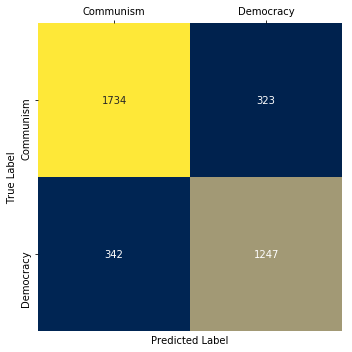

In [187]:
# created new confusion matrix for tuned model.
print('\n', metrics.classification_report(y_test, y_pred))

df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))
df_cm.rename({0: 'Communism', 1: 'Democracy'}, axis = 1, inplace = True)
df_cm.rename(index = {0: 'Communism', 1: 'Democracy'}, inplace = True)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.set_context(font_scale = 1.2)
sns.heatmap(df_cm, annot = True, fmt = 'g', cbar = False, cmap = 'cividis')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label');
ax.xaxis.set_ticks_position('top') 
plt.tight_layout()

In [188]:
coef_df = pd.DataFrame(logreg.coef_)
coef_df.columns = X.columns

In [189]:
coef_df

,num_trade_states,export_dollars,import_dollars,military_expenditure,military_personnel,prim_energy_consumption,total_pop,num_alliances,pre_1816_alliances,num_in_effect_1231_2012,defense_treaties,neutrality_treaties,nonaggression_treaties,entente_treaties,num_conflicts,avg_cum_duration,num_wars,ongoing_2010,Africa,Americas,Asia,Europe,Oceania,collective_leadership,military_leader,leader_died,war_present,40s,50s,60s,70s,80s,90s
0,0.643,4.665,0.000,0.000,-3.514,2.819,2.323,-15.893,0.000,4.079,9.823,1.082,-2.610,5.781,0.960,0.000,-0.004,-0.008,-1.354,-0.075,-0.496,1.081,1.512,0.000,-1.648,-0.284,0.293,-0.223,-0.448,-0.639,-1.259,-0.908,-0.309


In [190]:
coef_df.columns

Index(['num_trade_states', 'export_dollars', 'import_dollars',
       'military_expenditure', 'military_personnel', 'prim_energy_consumption',
       'total_pop', 'num_alliances', 'pre_1816_alliances',
       'num_in_effect_1231_2012', 'defense_treaties', 'neutrality_treaties',
       'nonaggression_treaties', 'entente_treaties', 'num_conflicts',
       'avg_cum_duration', 'num_wars', 'ongoing_2010', 'Africa', 'Americas',
       'Asia', 'Europe', 'Oceania', 'collective_leadership', 'military_leader',
       'leader_died', 'war_present', '40s', '50s', '60s', '70s', '80s', '90s'],
      dtype='object')